In [3]:
import deepSI
from deepSI import System_data, System_data_list
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
import os

from scipy.io import loadmat
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
from encoder_LPV_models import LPV_multi_encoder, LPV_single_encoder

In [5]:
#Remove exp_p
#3 Cases with 
# * Single use encoder
# * Multi measured encoder -> simulation with model output
# * Multi model    encoder -> simulation with model output
# - SS_encoder
# Sent data and bit of a figure.
# csv .mat
def loadsets(names, include_p=False):
    lis = []
    for n in names:
        out = loadmat(n)
        print(n)
        print(out.keys(),out['u_i2'].shape)
        u = np.concatenate([out['u_i2'],out['u_q1d'] if include_p else out['u_q1dref']],axis=1)
        y = out['y_q4d'][:,0]
        lis.append(deepSI.System_data(u=u,y=y))
    return deepSI.System_data_list(lis), out

m = './data/'

train_names = [m+i for i in os.listdir(m) if 'estim.' in i]
val_names = [m+i for i in os.listdir(m) if 'valid.' in i]
# train_names = ['data-roland/'+i for i in os.listdir('data-roland') if ('est' in i) and not ('4' in i)]
# val_names = ['data-roland/'+i for i in os.listdir('data-roland') if 'val' in i]
train, out = loadsets(train_names,include_p=True)
test, out = loadsets(val_names,include_p=True)
# val_frac = 0.10
# val = train[int(len(train)*(1-val_frac)):]
# train = train[:int(len(train)*(1-val_frac))]
# train, val, test

./cdc2022-dllpvid-main/software/data/ML_estim.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (10000, 1)
./cdc2022-dllpvid-main/software/data/ML_valid.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (30000, 1)


In [9]:
train0 = train[0]
test0 = test[0]
out = deepSI.fit_systems.grid_search(deepSI.fit_systems.SS_linear, train, sim_val=test0,\
                               fit_dict_choices=dict(SS_f=[5,10,20,40,100]),\
                               sys_dict_choices=dict(nx=[1,2,3,4,5,6]))

0.9051230555590362 {'nx': 1} {'SS_f': 5}
0.8888576052541025 {'nx': 1} {'SS_f': 10}
1.0217216577898658 {'nx': 1} {'SS_f': 20}
0.9941101144911795 {'nx': 1} {'SS_f': 40}
1.0522580440353384 {'nx': 1} {'SS_f': 100}
0.9019091548431528 {'nx': 2} {'SS_f': 5}
0.8893695279241561 {'nx': 2} {'SS_f': 10}
0.867074374512353 {'nx': 2} {'SS_f': 20}
0.8601236614010171 {'nx': 2} {'SS_f': 40}
0.7843973842413688 {'nx': 2} {'SS_f': 100}
0.8592701034416972 {'nx': 3} {'SS_f': 5}
0.8964605624131466 {'nx': 3} {'SS_f': 10}
0.8873821689197765 {'nx': 3} {'SS_f': 20}
0.852353866430484 {'nx': 3} {'SS_f': 40}
0.8122733302349044 {'nx': 3} {'SS_f': 100}
error x exploded, consider lowering nx or increasing SS_f or setting SS_A_stability=True for sys_dict= {'nx': 4} for fit_dict= {'SS_f': 5}
inf {'nx': 4} {'SS_f': 5}
0.8767907634703623 {'nx': 4} {'SS_f': 10}
0.8100659299729074 {'nx': 4} {'SS_f': 20}
0.8427548156209463 {'nx': 4} {'SS_f': 40}
0.7310219125302152 {'nx': 4} {'SS_f': 100}
0.8853288587347751 {'nx': 5} {'SS_f': 

In [11]:
1-out[0]

0.27406972479137415

In [3]:
sys = LPV_multi_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=True, f_net_kwargs=dict(F=10))
# sys.init_model(train)
# sys.apply_experiment(test[0][:1000])
# sys.filter_experiment(test[0][:1000])
sys.fit(train,test,epochs=100000, loss_kwargs=dict(nf=60,loss_nf_cutoff=0.20**2),concurrent_val=True)
sys.save_system('./models/LPV_multi-nx-5-Np-3-long-nf-60-include_u_in_p')

./cdc2022-dllpvid-main/software/data/ML_estim.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (10000, 1)
./cdc2022-dllpvid-main/software/data/ML_valid.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (30000, 1)
Initilizing the model and optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    1, sqrt loss  0.8061, Val sim-NRMS    nan, Time Loss: 95.1%, data: 4.9%, val: 0.0%,  0.0 vals/epoch, 172.4 batches/sec
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    2, sqrt loss  0.3715, Val sim-NRMS    nan, Time Loss: 95.2%, data: 4.2%, val: 0.6%,  0.0 vals/epoch, 219.0 batches/sec
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 Epoch    3, sqrt loss  0.3786, Val sim-NRMS    nan, Time Loss: 95.8%, data: 3.2%, val: 1.0%,  0.0 vals/epoch, 222.4 batches/sec
1 1 2 2 2 2 2 2 2 2 3 2 2 3 3 2 2 3 3 3 3 3 3 3 4 3 1 3 3 3 4 4 4 4 4 4 4 4 Epoch    4, sqrt loss  0.2216, Val sim-NRMS    nan, Time Loss: 96.2%, data: 2.5%, val: 1.1%,  0.0 vals/epoch, 186.8 batches/sec
4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 5 4 4 5 5 5 1 5 5 5 Epoch    5, sqrt loss   0.181, Val sim-NRMS    nan, Time Loss: 96.6%, data: 2.1%, val: 1.1%,  0.0 vals/epoch

47 Epoch   47, sqrt loss 0.06799, Val sim-NRMS    nan, Time Loss: 99.6%, data: 0.3%, val: 0.1%, 3.13 epochs/val,  6.4 batches/sec
53 55 50 57 51 Epoch   48, sqrt loss  0.1007, Val sim-NRMS    nan, Time Loss: 99.6%, data: 0.3%, val: 0.1%,  3.0 epochs/val,  6.4 batches/sec
Epoch   49, sqrt loss 0.05407, Val sim-NRMS    nan, Time Loss: 99.6%, data: 0.3%, val: 0.1%, 3.06 epochs/val,  6.4 batches/sec
Epoch   50, sqrt loss 0.04333, Val sim-NRMS 0.3899, Time Loss: 99.6%, data: 0.3%, val: 0.1%, 2.94 epochs/val,  6.4 batches/sec
Epoch   51, sqrt loss 0.04494, Val sim-NRMS 0.3899, Time Loss: 99.6%, data: 0.3%, val: 0.1%,  3.0 epochs/val,  6.4 batches/sec
Epoch   52, sqrt loss 0.04276, Val sim-NRMS 0.3899, Time Loss: 99.6%, data: 0.3%, val: 0.1%, 3.06 epochs/val,  6.4 batches/sec
56 42 57 44 28 23 ########## New lowest validation loss achieved ########### sim-NRMS = 0.2189421762953703
Epoch   53, sqrt loss 0.08306, Val sim-NRMS 0.2189, Time Loss: 99.6%, data: 0.3%, val: 0.1%, 2.94 epochs/val,  6.

Epoch  164, sqrt loss 0.02358, Val sim-NRMS 0.2391, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.69 epochs/val,  6.3 batches/sec
Epoch  165, sqrt loss 0.02277, Val sim-NRMS 0.1452, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.66 epochs/val,  6.3 batches/sec
Epoch  166, sqrt loss 0.02373, Val sim-NRMS 0.1452, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.68 epochs/val,  6.3 batches/sec
Epoch  167, sqrt loss 0.02348, Val sim-NRMS 0.1277, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.65 epochs/val,  6.3 batches/sec
Epoch  168, sqrt loss 0.02492, Val sim-NRMS 0.1277, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.67 epochs/val,  6.3 batches/sec
Epoch  169, sqrt loss 0.03467, Val sim-NRMS 0.1277, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.68 epochs/val,  6.2 batches/sec
Epoch  170, sqrt loss 0.04172, Val sim-NRMS 0.1477, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.66 epochs/val,  6.2 batches/sec
Epoch  171, sqrt loss 0.05458, Val sim-NRMS 0.1477, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.67 epochs/val,  

Epoch  224, sqrt loss 0.01989, Val sim-NRMS  0.169, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.64 epochs/val,  6.2 batches/sec
Epoch  225, sqrt loss 0.02638, Val sim-NRMS  0.169, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.65 epochs/val,  6.2 batches/sec
Epoch  226, sqrt loss 0.04157, Val sim-NRMS 0.1331, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.63 epochs/val,  6.2 batches/sec
51 57 50 Epoch  227, sqrt loss 0.08124, Val sim-NRMS 0.1331, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.64 epochs/val,  6.2 batches/sec
Epoch  228, sqrt loss  0.0279, Val sim-NRMS 0.2193, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.62 epochs/val,  6.2 batches/sec
Epoch  229, sqrt loss  0.0212, Val sim-NRMS 0.2193, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.63 epochs/val,  6.2 batches/sec
Epoch  230, sqrt loss 0.02048, Val sim-NRMS 0.2193, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.64 epochs/val,  6.2 batches/sec
Epoch  231, sqrt loss 0.01993, Val sim-NRMS 0.1234, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.62 epoc

Epoch  285, sqrt loss  0.0178, Val sim-NRMS 0.1136, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.61 epochs/val,  6.2 batches/sec
Epoch  286, sqrt loss 0.01865, Val sim-NRMS 0.09776, Time Loss: 99.7%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  287, sqrt loss 0.01893, Val sim-NRMS 0.09776, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.61 epochs/val,  6.2 batches/sec
Epoch  288, sqrt loss 0.02248, Val sim-NRMS 0.09776, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.62 epochs/val,  6.2 batches/sec
Epoch  289, sqrt loss  0.0255, Val sim-NRMS 0.1191, Time Loss: 99.7%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  290, sqrt loss 0.01991, Val sim-NRMS 0.1191, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.61 epochs/val,  6.2 batches/sec
Epoch  291, sqrt loss 0.02092, Val sim-NRMS  0.106, Time Loss: 99.7%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  292, sqrt loss 0.02243, Val sim-NRMS  0.106, Time Loss: 99.7%, data: 0.2%, val: 0.1%, 2.61 epochs/val

Epoch  346, sqrt loss 0.02956, Val sim-NRMS 0.1238, Time Loss: 99.8%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  347, sqrt loss 0.01808, Val sim-NRMS 0.2539, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.59 epochs/val,  6.2 batches/sec
Epoch  348, sqrt loss 0.01767, Val sim-NRMS 0.2539, Time Loss: 99.8%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  349, sqrt loss 0.01646, Val sim-NRMS 0.2539, Time Loss: 99.8%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  350, sqrt loss 0.01716, Val sim-NRMS 0.1032, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.59 epochs/val,  6.2 batches/sec
Epoch  351, sqrt loss 0.01656, Val sim-NRMS 0.1032, Time Loss: 99.8%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  6.2 batches/sec
Epoch  352, sqrt loss 0.01766, Val sim-NRMS 0.1316, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.59 epochs/val,  6.2 batches/sec
Epoch  353, sqrt loss 0.02089, Val sim-NRMS 0.1316, Time Loss: 99.8%, data: 0.2%, val: 0.1%,  2.6 epochs/val,  

########## New lowest validation loss achieved ########### sim-NRMS = 0.07201190204382318
Epoch  406, sqrt loss 0.03502, Val sim-NRMS 0.07201, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.57 epochs/val,  6.2 batches/sec
Epoch  407, sqrt loss 0.03365, Val sim-NRMS 0.07201, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.58 epochs/val,  6.2 batches/sec
Epoch  408, sqrt loss 0.02282, Val sim-NRMS 0.07201, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.58 epochs/val,  6.2 batches/sec
Epoch  409, sqrt loss 0.04412, Val sim-NRMS 0.3442, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.57 epochs/val,  6.2 batches/sec
Epoch  410, sqrt loss 0.01838, Val sim-NRMS 0.3442, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.58 epochs/val,  6.2 batches/sec
Epoch  411, sqrt loss   0.017, Val sim-NRMS 0.1773, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.57 epochs/val,  6.2 batches/sec
Epoch  412, sqrt loss 0.01819, Val sim-NRMS 0.1773, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.58 epochs/val,  6.2 batches/sec
Epoch  413, sqrt l

Epoch  467, sqrt loss 0.01958, Val sim-NRMS 0.0783, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.57 epochs/val,  6.2 batches/sec
Epoch  468, sqrt loss  0.0154, Val sim-NRMS 0.08005, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.56 epochs/val,  6.2 batches/sec
Epoch  469, sqrt loss 0.01748, Val sim-NRMS 0.08005, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.56 epochs/val,  6.2 batches/sec
Epoch  470, sqrt loss 0.01668, Val sim-NRMS 0.08005, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.57 epochs/val,  6.2 batches/sec
Epoch  471, sqrt loss 0.01648, Val sim-NRMS 0.1504, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.56 epochs/val,  6.2 batches/sec
Epoch  472, sqrt loss 0.01964, Val sim-NRMS 0.1504, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.57 epochs/val,  6.2 batches/sec
Epoch  473, sqrt loss 0.01731, Val sim-NRMS 0.09486, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.56 epochs/val,  6.2 batches/sec
Epoch  474, sqrt loss 0.02505, Val sim-NRMS 0.09486, Time Loss: 99.8%, data: 0.2%, val: 0.1%, 2.56 epochs/v

Epoch  531, sqrt loss 0.01479, Val sim-NRMS 0.1418, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  6.2 batches/sec
Epoch  532, sqrt loss 0.01541, Val sim-NRMS 0.0761, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  6.2 batches/sec
Epoch  533, sqrt loss   0.013, Val sim-NRMS 0.0761, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  6.2 batches/sec
Epoch  534, sqrt loss 0.01783, Val sim-NRMS 0.1023, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.54 epochs/val,  6.2 batches/sec
Epoch  535, sqrt loss 0.01937, Val sim-NRMS 0.1023, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  6.2 batches/sec
Epoch  536, sqrt loss   0.019, Val sim-NRMS 0.1023, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  6.2 batches/sec
Epoch  537, sqrt loss 0.02211, Val sim-NRMS 0.1274, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  6.2 batches/sec
Epoch  538, sqrt loss 0.03438, Val sim-NRMS 0.1274, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.55 epochs/val,  

Epoch  594, sqrt loss 0.01371, Val sim-NRMS 0.1171, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.54 epochs/val,  6.2 batches/sec
Epoch  595, sqrt loss 0.01823, Val sim-NRMS 0.08311, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.53 epochs/val,  6.2 batches/sec
Epoch  596, sqrt loss 0.02369, Val sim-NRMS 0.08311, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.54 epochs/val,  6.2 batches/sec
Epoch  597, sqrt loss 0.04506, Val sim-NRMS 0.08311, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.54 epochs/val,  6.1 batches/sec
Epoch  598, sqrt loss 0.03362, Val sim-NRMS 0.09071, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.53 epochs/val,  6.1 batches/sec
Epoch  599, sqrt loss 0.01688, Val sim-NRMS 0.09071, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.54 epochs/val,  6.1 batches/sec
Epoch  600, sqrt loss  0.0133, Val sim-NRMS 0.1234, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.53 epochs/val,  6.1 batches/sec
Epoch  601, sqrt loss 0.01271, Val sim-NRMS 0.1234, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.54 epochs/v

Epoch  659, sqrt loss 0.02598, Val sim-NRMS 0.06638, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epochs/val,  6.1 batches/sec
Epoch  660, sqrt loss 0.02097, Val sim-NRMS 0.06638, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.53 epochs/val,  6.1 batches/sec
Epoch  661, sqrt loss 0.01692, Val sim-NRMS 0.07866, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epochs/val,  6.1 batches/sec
Epoch  662, sqrt loss 0.02219, Val sim-NRMS 0.07866, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.53 epochs/val,  6.1 batches/sec
Epoch  663, sqrt loss 0.01859, Val sim-NRMS 0.06712, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epochs/val,  6.1 batches/sec
Epoch  664, sqrt loss 0.01968, Val sim-NRMS 0.06712, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epochs/val,  6.1 batches/sec
Epoch  665, sqrt loss 0.03249, Val sim-NRMS 0.07112, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epochs/val,  6.1 batches/sec
Epoch  666, sqrt loss 0.04086, Val sim-NRMS 0.07112, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epoch

Epoch  721, sqrt loss  0.0264, Val sim-NRMS 0.1189, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  722, sqrt loss 0.01366, Val sim-NRMS 0.1189, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.52 epochs/val,  6.1 batches/sec
Epoch  723, sqrt loss 0.01132, Val sim-NRMS 0.1517, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  724, sqrt loss 0.01422, Val sim-NRMS 0.1517, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  725, sqrt loss 0.01678, Val sim-NRMS 0.05115, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  726, sqrt loss 0.02108, Val sim-NRMS 0.05115, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  727, sqrt loss 0.01612, Val sim-NRMS 0.08563, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  728, sqrt loss 0.03281, Val sim-NRMS 0.08563, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/va

Epoch  784, sqrt loss 0.01636, Val sim-NRMS 0.1776, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  785, sqrt loss 0.01841, Val sim-NRMS 0.1776, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  786, sqrt loss 0.02725, Val sim-NRMS 0.1158, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  787, sqrt loss  0.0123, Val sim-NRMS 0.1158, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  788, sqrt loss 0.01504, Val sim-NRMS 0.1455, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  789, sqrt loss 0.01178, Val sim-NRMS 0.1455, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  790, sqrt loss 0.01759, Val sim-NRMS 0.1455, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.51 epochs/val,  6.1 batches/sec
Epoch  791, sqrt loss 0.03124, Val sim-NRMS 0.06917, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val, 

Epoch  847, sqrt loss  0.0302, Val sim-NRMS 0.04525, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  848, sqrt loss  0.0182, Val sim-NRMS 0.04525, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  849, sqrt loss  0.0164, Val sim-NRMS 0.1231, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  850, sqrt loss 0.01522, Val sim-NRMS 0.1231, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
38 29 50 44 Epoch  851, sqrt loss 0.06227, Val sim-NRMS 0.1181, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
44 43 45 59 54 59 55 Epoch  852, sqrt loss 0.09246, Val sim-NRMS 0.1181, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  853, sqrt loss 0.02874, Val sim-NRMS 0.1181, Time Loss: 99.8%, data: 0.1%, val: 0.1%,  2.5 epochs/val,  6.1 batches/sec
Epoch  854, sqrt loss 0.01318, Val sim-NRMS    nan, Time Loss: 99.8%, data: 

Epoch  911, sqrt loss 0.02281, Val sim-NRMS 0.2287, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  912, sqrt loss 0.02188, Val sim-NRMS 0.2287, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  913, sqrt loss  0.0246, Val sim-NRMS 0.2287, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  914, sqrt loss 0.02746, Val sim-NRMS 0.2906, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  915, sqrt loss 0.02775, Val sim-NRMS 0.2906, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  916, sqrt loss 0.01379, Val sim-NRMS 0.2181, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  917, sqrt loss 0.01491, Val sim-NRMS 0.2181, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  918, sqrt loss  0.0163, Val sim-NRMS 0.2181, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  

Epoch  975, sqrt loss 0.01266, Val sim-NRMS 0.04671, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  976, sqrt loss 0.01576, Val sim-NRMS 0.04671, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  977, sqrt loss 0.01423, Val sim-NRMS 0.1035, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  978, sqrt loss 0.01248, Val sim-NRMS 0.1035, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  979, sqrt loss 0.01793, Val sim-NRMS 0.06315, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
Epoch  980, sqrt loss 0.02768, Val sim-NRMS 0.06315, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  981, sqrt loss 0.01436, Val sim-NRMS 0.06315, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/val,  6.1 batches/sec
Epoch  982, sqrt loss 0.01678, Val sim-NRMS 0.1299, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.49 epochs/v

Epoch 1040, sqrt loss 0.02171, Val sim-NRMS 0.1288, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
Epoch 1041, sqrt loss 0.01314, Val sim-NRMS 0.1288, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
Epoch 1042, sqrt loss 0.01194, Val sim-NRMS 0.1887, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
Epoch 1043, sqrt loss 0.02281, Val sim-NRMS 0.1887, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
49 59 27 23 44 Epoch 1044, sqrt loss 0.06058, Val sim-NRMS 0.05356, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
26 14 10 9 11 14 16 17 18 20 28 33 1 16 52 Epoch 1045, sqrt loss   0.122, Val sim-NRMS 0.05356, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
60 49 51 43 54 51 55 33 37 Epoch 1046, sqrt loss 0.09303, Val sim-NRMS 0.05356, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.1 batches/sec
Epoch 1047, sqrt loss 0

Epoch 1103, sqrt loss 0.02999, Val sim-NRMS 0.0576, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1104, sqrt loss 0.02163, Val sim-NRMS 0.0576, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1105, sqrt loss 0.01224, Val sim-NRMS  0.431, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1106, sqrt loss 0.02219, Val sim-NRMS  0.431, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1107, sqrt loss 0.01998, Val sim-NRMS 0.06645, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1108, sqrt loss 0.01668, Val sim-NRMS 0.06645, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1109, sqrt loss 0.01348, Val sim-NRMS 0.06645, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1110, sqrt loss 0.03114, Val sim-NRMS 0.1345, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val

Epoch 1168, sqrt loss 0.01002, Val sim-NRMS 0.2844, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1169, sqrt loss 0.01019, Val sim-NRMS 0.2844, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1170, sqrt loss 0.01049, Val sim-NRMS 0.04747, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1171, sqrt loss 0.01063, Val sim-NRMS 0.04747, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
Epoch 1172, sqrt loss 0.009907, Val sim-NRMS 0.05756, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1173, sqrt loss 0.01011, Val sim-NRMS 0.05756, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1174, sqrt loss 0.009804, Val sim-NRMS 0.05756, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.48 epochs/val,  6.0 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0325717229383825
Epoch 1175, sqr

Epoch 1231, sqrt loss 0.01497, Val sim-NRMS 0.05883, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1232, sqrt loss 0.02539, Val sim-NRMS 0.05883, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
48 59 Epoch 1233, sqrt loss 0.06283, Val sim-NRMS 0.08917, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
56 58 56 Epoch 1234, sqrt loss  0.0918, Val sim-NRMS 0.08917, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1235, sqrt loss 0.02954, Val sim-NRMS 0.07803, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1236, sqrt loss 0.01109, Val sim-NRMS 0.07803, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1237, sqrt loss 0.01005, Val sim-NRMS 0.1255, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1238, sqrt loss 0.009875, Val sim-NRMS 0.1255, Time Loss: 99.8%, data: 0.1%, val: 0.

Epoch 1295, sqrt loss 0.03739, Val sim-NRMS 0.05498, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
59 28 38 44 33 27 38 Epoch 1296, sqrt loss  0.1056, Val sim-NRMS 0.05498, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1297, sqrt loss 0.03806, Val sim-NRMS 0.05498, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1298, sqrt loss 0.01382, Val sim-NRMS 0.1226, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1299, sqrt loss 0.01034, Val sim-NRMS 0.1226, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1300, sqrt loss 0.01012, Val sim-NRMS 0.06754, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1301, sqrt loss 0.009797, Val sim-NRMS 0.06754, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1302, sqrt loss 0.00933, Val sim-NRMS 0.05275, Time Loss: 99.8%, data: 0.1%, v

Epoch 1359, sqrt loss 0.01063, Val sim-NRMS 0.09585, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1360, sqrt loss 0.01086, Val sim-NRMS 0.1133, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1361, sqrt loss  0.0101, Val sim-NRMS 0.1133, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1362, sqrt loss 0.01067, Val sim-NRMS 0.1133, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1363, sqrt loss 0.009908, Val sim-NRMS 0.04171, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1364, sqrt loss 0.01008, Val sim-NRMS 0.04171, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/val,  6.0 batches/sec
Epoch 1365, sqrt loss 0.00899, Val sim-NRMS 0.03571, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1366, sqrt loss 0.01017, Val sim-NRMS 0.03571, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.47 epochs/

Epoch 1423, sqrt loss 0.02071, Val sim-NRMS 0.05002, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1424, sqrt loss 0.01399, Val sim-NRMS 0.05002, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1425, sqrt loss 0.01344, Val sim-NRMS 0.05995, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1426, sqrt loss 0.01652, Val sim-NRMS 0.05995, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1427, sqrt loss 0.01443, Val sim-NRMS 0.05995, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1428, sqrt loss 0.01624, Val sim-NRMS 0.09806, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1429, sqrt loss 0.03084, Val sim-NRMS 0.09806, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1430, sqrt loss 0.02676, Val sim-NRMS 0.04921, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epoch

Epoch 1486, sqrt loss 0.01012, Val sim-NRMS 0.4558, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1487, sqrt loss 0.01009, Val sim-NRMS 0.4558, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1488, sqrt loss 0.009992, Val sim-NRMS 0.04967, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1489, sqrt loss 0.009002, Val sim-NRMS 0.04967, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1490, sqrt loss 0.008977, Val sim-NRMS 0.04967, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1491, sqrt loss 0.009814, Val sim-NRMS 0.05543, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1492, sqrt loss 0.01007, Val sim-NRMS 0.05543, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.027548966567403233
Epoch 1493,

Epoch 1550, sqrt loss 0.02698, Val sim-NRMS 0.1023, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1551, sqrt loss  0.0533, Val sim-NRMS 0.08463, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
46 Epoch 1552, sqrt loss 0.06118, Val sim-NRMS 0.08463, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1553, sqrt loss 0.01762, Val sim-NRMS 0.2392, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1554, sqrt loss 0.009475, Val sim-NRMS 0.2392, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1555, sqrt loss 0.008945, Val sim-NRMS 0.2392, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1556, sqrt loss 0.009514, Val sim-NRMS 0.03567, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1557, sqrt loss 0.009727, Val sim-NRMS 0.03567, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 ep

########## New lowest validation loss achieved ########### sim-NRMS = 0.026895104502597383
Epoch 1614, sqrt loss 0.009081, Val sim-NRMS 0.0269, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1615, sqrt loss 0.009708, Val sim-NRMS 0.0269, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1616, sqrt loss 0.009537, Val sim-NRMS 0.03684, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1617, sqrt loss 0.009888, Val sim-NRMS 0.03684, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1618, sqrt loss 0.01023, Val sim-NRMS 0.05026, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1619, sqrt loss 0.00969, Val sim-NRMS 0.05026, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1620, sqrt loss 0.009371, Val sim-NRMS 0.05026, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1621

Epoch 1678, sqrt loss 0.01429, Val sim-NRMS 0.03545, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1679, sqrt loss 0.01169, Val sim-NRMS 0.06251, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1680, sqrt loss 0.01487, Val sim-NRMS 0.06251, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1681, sqrt loss 0.01279, Val sim-NRMS 0.0489, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1682, sqrt loss  0.0131, Val sim-NRMS 0.0489, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1683, sqrt loss 0.01121, Val sim-NRMS 0.0489, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1684, sqrt loss 0.01813, Val sim-NRMS 0.07067, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1685, sqrt loss 0.03022, Val sim-NRMS 0.07067, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/v

Epoch 1742, sqrt loss 0.04747, Val sim-NRMS 0.06377, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
41 Epoch 1743, sqrt loss  0.0634, Val sim-NRMS 0.06377, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1744, sqrt loss 0.02783, Val sim-NRMS 0.1071, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1745, sqrt loss 0.01072, Val sim-NRMS 0.1071, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1746, sqrt loss 0.009021, Val sim-NRMS 0.1363, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1747, sqrt loss 0.009608, Val sim-NRMS 0.1363, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1748, sqrt loss 0.00863, Val sim-NRMS 0.1363, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.46 epochs/val,  6.0 batches/sec
Epoch 1749, sqrt loss 0.008483, Val sim-NRMS 0.03699, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epoc

Epoch 1806, sqrt loss 0.01766, Val sim-NRMS 0.03909, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1807, sqrt loss 0.02421, Val sim-NRMS 0.1044, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1808, sqrt loss 0.01939, Val sim-NRMS 0.1044, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1809, sqrt loss 0.01164, Val sim-NRMS 0.1234, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1810, sqrt loss 0.009709, Val sim-NRMS 0.1234, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1811, sqrt loss 0.01611, Val sim-NRMS 0.1234, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1812, sqrt loss  0.0204, Val sim-NRMS 0.02714, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1813, sqrt loss  0.0241, Val sim-NRMS 0.02714, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/va

Epoch 1870, sqrt loss 0.01096, Val sim-NRMS 0.04286, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1871, sqrt loss  0.0129, Val sim-NRMS 0.04286, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1872, sqrt loss 0.01247, Val sim-NRMS 0.04533, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1873, sqrt loss 0.02453, Val sim-NRMS 0.04533, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1874, sqrt loss  0.0167, Val sim-NRMS 0.08064, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1875, sqrt loss 0.01507, Val sim-NRMS 0.08064, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1876, sqrt loss 0.01079, Val sim-NRMS 0.08064, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1877, sqrt loss 0.01017, Val sim-NRMS 0.07357, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epoch

Epoch 1934, sqrt loss  0.0154, Val sim-NRMS   0.11, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1935, sqrt loss 0.01939, Val sim-NRMS   0.11, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1936, sqrt loss 0.01274, Val sim-NRMS   0.11, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1937, sqrt loss 0.01178, Val sim-NRMS 0.04984, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1938, sqrt loss 0.01262, Val sim-NRMS 0.04984, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1939, sqrt loss 0.01487, Val sim-NRMS 0.0599, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1940, sqrt loss 0.03792, Val sim-NRMS 0.0599, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1941, sqrt loss 0.02208, Val sim-NRMS 0.0599, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,

Epoch 1998, sqrt loss 0.02273, Val sim-NRMS   0.15, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 1999, sqrt loss  0.0124, Val sim-NRMS   0.15, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2000, sqrt loss 0.009938, Val sim-NRMS 0.0525, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2001, sqrt loss 0.01171, Val sim-NRMS 0.0525, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2002, sqrt loss 0.01411, Val sim-NRMS 0.05439, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2003, sqrt loss 0.01279, Val sim-NRMS 0.05439, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2004, sqrt loss 0.01728, Val sim-NRMS 0.05439, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2005, sqrt loss 0.01917, Val sim-NRMS 0.05923, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/v

Epoch 2062, sqrt loss 0.009072, Val sim-NRMS 0.05647, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2063, sqrt loss 0.01233, Val sim-NRMS 0.05647, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2064, sqrt loss 0.01099, Val sim-NRMS 0.05647, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2065, sqrt loss 0.01088, Val sim-NRMS 0.04799, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2066, sqrt loss 0.01406, Val sim-NRMS 0.04799, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2067, sqrt loss 0.01073, Val sim-NRMS 0.06242, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2068, sqrt loss 0.01229, Val sim-NRMS 0.06242, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2069, sqrt loss 0.01102, Val sim-NRMS 0.06242, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epoc

Epoch 2127, sqrt loss 0.01099, Val sim-NRMS 0.06866, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2128, sqrt loss 0.02395, Val sim-NRMS 0.06866, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2129, sqrt loss 0.01654, Val sim-NRMS 0.06866, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2130, sqrt loss 0.01599, Val sim-NRMS 0.02953, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2131, sqrt loss 0.01358, Val sim-NRMS 0.02953, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2132, sqrt loss 0.01505, Val sim-NRMS 0.06885, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2133, sqrt loss 0.01885, Val sim-NRMS 0.06885, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2134, sqrt loss 0.01849, Val sim-NRMS 0.06885, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epoch

Epoch 2191, sqrt loss 0.01633, Val sim-NRMS 0.1301, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2192, sqrt loss 0.01486, Val sim-NRMS 0.06937, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2193, sqrt loss 0.01517, Val sim-NRMS 0.06937, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2194, sqrt loss   0.028, Val sim-NRMS 0.06937, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2195, sqrt loss   0.022, Val sim-NRMS 0.04647, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2196, sqrt loss 0.01234, Val sim-NRMS 0.04647, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2197, sqrt loss 0.01506, Val sim-NRMS  0.108, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2198, sqrt loss 0.01097, Val sim-NRMS  0.108, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/v

Epoch 2255, sqrt loss 0.01177, Val sim-NRMS 0.04546, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2256, sqrt loss 0.01828, Val sim-NRMS 0.04546, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2257, sqrt loss 0.02548, Val sim-NRMS 0.04546, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.45 epochs/val,  6.0 batches/sec
Epoch 2258, sqrt loss 0.01299, Val sim-NRMS 0.1177, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2259, sqrt loss 0.008293, Val sim-NRMS 0.1177, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2260, sqrt loss 0.008119, Val sim-NRMS 0.1103, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2261, sqrt loss 0.008603, Val sim-NRMS 0.1103, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2262, sqrt loss 0.01039, Val sim-NRMS 0.03856, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs

49 Epoch 2319, sqrt loss 0.07599, Val sim-NRMS 0.03871, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2320, sqrt loss 0.02187, Val sim-NRMS 0.1344, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2321, sqrt loss 0.01019, Val sim-NRMS 0.1344, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2322, sqrt loss 0.008675, Val sim-NRMS 0.1344, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2323, sqrt loss 0.007975, Val sim-NRMS 0.1069, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2324, sqrt loss 0.007894, Val sim-NRMS 0.1069, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2325, sqrt loss 0.00795, Val sim-NRMS 0.03319, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2326, sqrt loss 0.007782, Val sim-NRMS 0.03319, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epo

Epoch 2383, sqrt loss 0.008265, Val sim-NRMS 0.03485, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2384, sqrt loss 0.009424, Val sim-NRMS 0.04893, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2385, sqrt loss 0.009732, Val sim-NRMS 0.04893, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2386, sqrt loss 0.008351, Val sim-NRMS 0.0435, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2387, sqrt loss 0.01057, Val sim-NRMS 0.0435, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2388, sqrt loss 0.009864, Val sim-NRMS 0.0435, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2389, sqrt loss 0.009846, Val sim-NRMS 0.06766, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2390, sqrt loss 0.01071, Val sim-NRMS 0.06766, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 ep

Epoch 2447, sqrt loss 0.04486, Val sim-NRMS 0.1126, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2448, sqrt loss 0.01295, Val sim-NRMS 0.1126, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2449, sqrt loss 0.008952, Val sim-NRMS 0.6571, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2450, sqrt loss 0.008662, Val sim-NRMS 0.6571, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2451, sqrt loss 0.008651, Val sim-NRMS 0.03742, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2452, sqrt loss 0.008254, Val sim-NRMS 0.03742, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2453, sqrt loss 0.007892, Val sim-NRMS 0.03742, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2454, sqrt loss 0.009268, Val sim-NRMS 0.04664, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epo

Epoch 2511, sqrt loss 0.01133, Val sim-NRMS 0.05472, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2512, sqrt loss 0.01804, Val sim-NRMS 0.05472, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2513, sqrt loss  0.0126, Val sim-NRMS 0.05472, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2514, sqrt loss 0.01454, Val sim-NRMS 0.1096, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2515, sqrt loss 0.01067, Val sim-NRMS 0.1096, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2516, sqrt loss 0.01146, Val sim-NRMS 0.1167, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2517, sqrt loss 0.01164, Val sim-NRMS 0.1167, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2518, sqrt loss  0.0106, Val sim-NRMS 0.09721, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/va

Epoch 2576, sqrt loss  0.0158, Val sim-NRMS 0.07873, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2577, sqrt loss 0.02092, Val sim-NRMS 0.07873, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2578, sqrt loss 0.01331, Val sim-NRMS 0.1148, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2579, sqrt loss 0.01165, Val sim-NRMS 0.1148, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2580, sqrt loss 0.01415, Val sim-NRMS 0.1148, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2581, sqrt loss 0.01468, Val sim-NRMS 0.06522, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2582, sqrt loss 0.01213, Val sim-NRMS 0.06522, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2583, sqrt loss 0.01148, Val sim-NRMS 0.0897, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/va

Epoch 2641, sqrt loss 0.008684, Val sim-NRMS 0.04692, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2642, sqrt loss 0.008419, Val sim-NRMS 0.04692, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2643, sqrt loss 0.01064, Val sim-NRMS 0.03473, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2644, sqrt loss 0.01002, Val sim-NRMS 0.03473, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2645, sqrt loss 0.008896, Val sim-NRMS 0.03473, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2646, sqrt loss 0.008582, Val sim-NRMS 0.1175, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2647, sqrt loss 0.009128, Val sim-NRMS 0.1175, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2648, sqrt loss 0.01115, Val sim-NRMS 0.03114, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 ep

Epoch 2705, sqrt loss 0.008453, Val sim-NRMS 0.04414, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2706, sqrt loss 0.008216, Val sim-NRMS 0.03503, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2707, sqrt loss 0.008401, Val sim-NRMS 0.03503, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2708, sqrt loss 0.008463, Val sim-NRMS 0.03732, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2709, sqrt loss 0.008314, Val sim-NRMS 0.03732, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2710, sqrt loss 0.008662, Val sim-NRMS 0.03732, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2711, sqrt loss 0.007744, Val sim-NRMS 0.03784, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2712, sqrt loss 0.007982, Val sim-NRMS 0.03784, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.

Epoch 2769, sqrt loss 0.008165, Val sim-NRMS 0.07099, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2770, sqrt loss 0.007878, Val sim-NRMS 0.1041, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2771, sqrt loss 0.008863, Val sim-NRMS 0.1041, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2772, sqrt loss 0.008922, Val sim-NRMS 0.1041, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2773, sqrt loss 0.01149, Val sim-NRMS 0.0486, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2774, sqrt loss 0.01351, Val sim-NRMS 0.0486, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2775, sqrt loss 0.01198, Val sim-NRMS 0.08158, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2776, sqrt loss 0.02089, Val sim-NRMS 0.08158, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs

Epoch 2833, sqrt loss 0.01221, Val sim-NRMS 0.03194, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2834, sqrt loss   0.015, Val sim-NRMS 0.03194, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2835, sqrt loss 0.01623, Val sim-NRMS 0.0537, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2836, sqrt loss 0.02143, Val sim-NRMS 0.0537, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2837, sqrt loss 0.01615, Val sim-NRMS 0.0537, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.44 epochs/val,  6.0 batches/sec
Epoch 2838, sqrt loss 0.03114, Val sim-NRMS 0.05806, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2839, sqrt loss 0.01331, Val sim-NRMS 0.05806, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2840, sqrt loss 0.00917, Val sim-NRMS 0.1805, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/va

Epoch 2897, sqrt loss 0.008577, Val sim-NRMS 0.08579, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2898, sqrt loss 0.01081, Val sim-NRMS 0.07693, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2899, sqrt loss 0.01543, Val sim-NRMS 0.07693, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2900, sqrt loss 0.02133, Val sim-NRMS 0.07693, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2901, sqrt loss 0.01141, Val sim-NRMS 0.03131, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2902, sqrt loss 0.008718, Val sim-NRMS 0.03131, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2903, sqrt loss 0.009438, Val sim-NRMS 0.09182, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2904, sqrt loss 0.01485, Val sim-NRMS 0.09182, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 ep

Epoch 2961, sqrt loss 0.01006, Val sim-NRMS 0.08652, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2962, sqrt loss 0.01008, Val sim-NRMS 0.08652, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2963, sqrt loss 0.01221, Val sim-NRMS 0.03667, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2964, sqrt loss 0.01037, Val sim-NRMS 0.03667, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2965, sqrt loss 0.01391, Val sim-NRMS 0.03667, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2966, sqrt loss 0.01097, Val sim-NRMS 0.07657, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2967, sqrt loss 0.01046, Val sim-NRMS 0.07657, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 2968, sqrt loss 0.01255, Val sim-NRMS 0.1153, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs

Epoch 3025, sqrt loss 0.009672, Val sim-NRMS 0.05624, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3026, sqrt loss 0.009655, Val sim-NRMS 0.06815, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3027, sqrt loss 0.03502, Val sim-NRMS 0.06815, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3028, sqrt loss 0.01974, Val sim-NRMS 0.05781, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3029, sqrt loss 0.009194, Val sim-NRMS 0.05781, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3030, sqrt loss 0.007917, Val sim-NRMS 0.05781, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3031, sqrt loss 0.009136, Val sim-NRMS 0.1153, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3032, sqrt loss 0.008075, Val sim-NRMS 0.1153, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 e

Epoch 3089, sqrt loss 0.007932, Val sim-NRMS 0.03242, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3090, sqrt loss 0.008148, Val sim-NRMS 0.03242, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3091, sqrt loss 0.008831, Val sim-NRMS 0.03378, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3092, sqrt loss 0.009198, Val sim-NRMS 0.03378, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3093, sqrt loss 0.008347, Val sim-NRMS 0.03909, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3094, sqrt loss 0.01034, Val sim-NRMS 0.03909, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3095, sqrt loss 0.007554, Val sim-NRMS 0.03909, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3096, sqrt loss 0.007917, Val sim-NRMS 0.05535, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.4

Epoch 3153, sqrt loss  0.0107, Val sim-NRMS 0.03915, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3154, sqrt loss 0.01063, Val sim-NRMS 0.05243, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3155, sqrt loss 0.01754, Val sim-NRMS 0.05243, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3156, sqrt loss 0.01413, Val sim-NRMS 0.08089, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3157, sqrt loss 0.01121, Val sim-NRMS 0.08089, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3158, sqrt loss 0.01212, Val sim-NRMS 0.08089, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3159, sqrt loss 0.008401, Val sim-NRMS 0.06685, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3160, sqrt loss 0.01167, Val sim-NRMS 0.06685, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epoc

Epoch 3218, sqrt loss 0.01042, Val sim-NRMS 0.05192, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3219, sqrt loss 0.008989, Val sim-NRMS 0.05413, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3220, sqrt loss 0.009876, Val sim-NRMS 0.05413, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3221, sqrt loss  0.0172, Val sim-NRMS 0.03413, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3222, sqrt loss 0.01176, Val sim-NRMS 0.03413, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3223, sqrt loss 0.009389, Val sim-NRMS 0.03413, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3224, sqrt loss 0.00841, Val sim-NRMS 0.05969, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3225, sqrt loss 0.01087, Val sim-NRMS 0.05969, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 ep

Epoch 3282, sqrt loss 0.008307, Val sim-NRMS 0.06275, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3283, sqrt loss 0.007868, Val sim-NRMS 0.06275, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3284, sqrt loss 0.008175, Val sim-NRMS 0.02915, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3285, sqrt loss 0.009195, Val sim-NRMS 0.02915, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3286, sqrt loss 0.008737, Val sim-NRMS 0.02899, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3287, sqrt loss 0.01118, Val sim-NRMS 0.02899, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3288, sqrt loss 0.01261, Val sim-NRMS 0.02899, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3289, sqrt loss 0.01763, Val sim-NRMS 0.02836, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 

Epoch 3346, sqrt loss  0.0098, Val sim-NRMS 0.0565, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3347, sqrt loss 0.01103, Val sim-NRMS 0.0565, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3348, sqrt loss 0.01263, Val sim-NRMS 0.0565, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3349, sqrt loss 0.009099, Val sim-NRMS 0.05812, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3350, sqrt loss 0.01059, Val sim-NRMS 0.05812, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3351, sqrt loss 0.01296, Val sim-NRMS 0.02878, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3352, sqrt loss 0.01335, Val sim-NRMS 0.02878, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3353, sqrt loss 0.01332, Val sim-NRMS 0.02878, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/

Epoch 3411, sqrt loss 0.01046, Val sim-NRMS 0.03334, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3412, sqrt loss 0.01175, Val sim-NRMS 0.03334, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3413, sqrt loss 0.01519, Val sim-NRMS 0.03334, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3414, sqrt loss 0.01774, Val sim-NRMS 0.1093, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3415, sqrt loss 0.01813, Val sim-NRMS 0.1093, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3416, sqrt loss 0.02146, Val sim-NRMS 0.1149, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3417, sqrt loss 0.01058, Val sim-NRMS 0.1149, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3418, sqrt loss 0.01056, Val sim-NRMS 0.1149, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val

Epoch 3475, sqrt loss 0.008324, Val sim-NRMS 0.1031, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3476, sqrt loss 0.008438, Val sim-NRMS 0.02839, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3477, sqrt loss 0.009674, Val sim-NRMS 0.02839, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3478, sqrt loss 0.00787, Val sim-NRMS 0.02839, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3479, sqrt loss 0.009131, Val sim-NRMS 0.03366, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3480, sqrt loss 0.01075, Val sim-NRMS 0.03366, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3481, sqrt loss 0.01506, Val sim-NRMS 0.04598, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3482, sqrt loss 0.02001, Val sim-NRMS 0.04598, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 ep

Epoch 3539, sqrt loss 0.009091, Val sim-NRMS 0.05388, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3540, sqrt loss 0.008046, Val sim-NRMS 0.05388, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3541, sqrt loss 0.007759, Val sim-NRMS 0.03676, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3542, sqrt loss 0.007671, Val sim-NRMS 0.03676, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3543, sqrt loss 0.007664, Val sim-NRMS 0.03676, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3544, sqrt loss 0.007267, Val sim-NRMS 0.02811, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3545, sqrt loss 0.008497, Val sim-NRMS 0.02811, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3546, sqrt loss 0.008407, Val sim-NRMS 0.02955, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.

Epoch 3603, sqrt loss 0.01722, Val sim-NRMS 0.06863, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3604, sqrt loss 0.01893, Val sim-NRMS 0.0353, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3605, sqrt loss 0.008663, Val sim-NRMS 0.0353, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3606, sqrt loss 0.007846, Val sim-NRMS 0.0353, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3607, sqrt loss 0.009925, Val sim-NRMS 0.07176, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3608, sqrt loss 0.01084, Val sim-NRMS 0.07176, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3609, sqrt loss 0.009423, Val sim-NRMS 0.03255, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3610, sqrt loss 0.01085, Val sim-NRMS 0.03255, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epoc

Epoch 3667, sqrt loss 0.01552, Val sim-NRMS 0.06292, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3668, sqrt loss  0.0129, Val sim-NRMS 0.06292, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3669, sqrt loss 0.01393, Val sim-NRMS 0.05305, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3670, sqrt loss 0.01317, Val sim-NRMS 0.05305, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3671, sqrt loss 0.01002, Val sim-NRMS 0.05305, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3672, sqrt loss 0.01091, Val sim-NRMS 0.1396, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3673, sqrt loss 0.01401, Val sim-NRMS 0.1396, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3674, sqrt loss 0.009225, Val sim-NRMS 0.06668, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs

Epoch 3731, sqrt loss 0.01052, Val sim-NRMS 0.08516, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3732, sqrt loss 0.01477, Val sim-NRMS 0.1544, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3733, sqrt loss 0.01057, Val sim-NRMS 0.1544, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3734, sqrt loss 0.01243, Val sim-NRMS 0.0824, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3735, sqrt loss 0.009598, Val sim-NRMS 0.0824, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3736, sqrt loss 0.008606, Val sim-NRMS 0.0824, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3737, sqrt loss 0.009108, Val sim-NRMS 0.04993, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3738, sqrt loss 0.009403, Val sim-NRMS 0.04993, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs

Epoch 3795, sqrt loss 0.01139, Val sim-NRMS 0.06578, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3796, sqrt loss 0.01122, Val sim-NRMS 0.06578, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3797, sqrt loss 0.01091, Val sim-NRMS 0.1563, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3798, sqrt loss 0.009656, Val sim-NRMS 0.1563, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3799, sqrt loss 0.01074, Val sim-NRMS 0.06315, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3800, sqrt loss 0.01222, Val sim-NRMS 0.06315, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3801, sqrt loss 0.01168, Val sim-NRMS 0.06315, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3802, sqrt loss 0.01129, Val sim-NRMS 0.04712, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs

Epoch 3859, sqrt loss 0.008204, Val sim-NRMS 0.02475, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3860, sqrt loss 0.01217, Val sim-NRMS 0.02475, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3861, sqrt loss 0.01701, Val sim-NRMS 0.02475, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3862, sqrt loss 0.009918, Val sim-NRMS 0.05797, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3863, sqrt loss 0.009925, Val sim-NRMS 0.05797, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3864, sqrt loss  0.0117, Val sim-NRMS 0.05155, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3865, sqrt loss 0.01129, Val sim-NRMS 0.05155, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3866, sqrt loss 0.009021, Val sim-NRMS 0.05155, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 e

Epoch 3923, sqrt loss 0.008634, Val sim-NRMS 0.0623, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3924, sqrt loss 0.01538, Val sim-NRMS 0.0623, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3925, sqrt loss 0.009718, Val sim-NRMS 0.0623, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3926, sqrt loss 0.008811, Val sim-NRMS 0.05178, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3927, sqrt loss 0.01021, Val sim-NRMS 0.05178, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3928, sqrt loss 0.009954, Val sim-NRMS 0.04875, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3929, sqrt loss 0.01675, Val sim-NRMS 0.04875, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3930, sqrt loss 0.01468, Val sim-NRMS 0.03999, Time Loss: 99.8%, data: 0.1%, val: 0.1%, 2.43 epoc

Epoch 3987, sqrt loss 0.007782, Val sim-NRMS 0.1129, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3988, sqrt loss 0.008297, Val sim-NRMS 0.04847, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3989, sqrt loss 0.008624, Val sim-NRMS 0.04847, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3990, sqrt loss 0.008866, Val sim-NRMS 0.04847, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3991, sqrt loss 0.008368, Val sim-NRMS 0.04285, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3992, sqrt loss 0.008388, Val sim-NRMS 0.04285, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3993, sqrt loss 0.008831, Val sim-NRMS 0.02772, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 3994, sqrt loss 0.01594, Val sim-NRMS 0.02772, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43

Epoch 4051, sqrt loss 0.008663, Val sim-NRMS 0.04076, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4052, sqrt loss 0.009158, Val sim-NRMS 0.04076, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4053, sqrt loss 0.009855, Val sim-NRMS 0.04255, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4054, sqrt loss 0.01064, Val sim-NRMS 0.04255, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4055, sqrt loss 0.009904, Val sim-NRMS 0.04255, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4056, sqrt loss 0.01669, Val sim-NRMS 0.03539, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4057, sqrt loss 0.01244, Val sim-NRMS 0.03539, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4058, sqrt loss 0.02596, Val sim-NRMS 0.05622, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 e

Epoch 4115, sqrt loss 0.01039, Val sim-NRMS 0.0289, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4116, sqrt loss 0.01307, Val sim-NRMS 0.07023, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4117, sqrt loss 0.01305, Val sim-NRMS 0.07023, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4118, sqrt loss 0.01235, Val sim-NRMS 0.05283, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4119, sqrt loss 0.03241, Val sim-NRMS 0.05283, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
55 Epoch 4120, sqrt loss 0.07289, Val sim-NRMS 0.07026, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4121, sqrt loss 0.02081, Val sim-NRMS 0.07026, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4122, sqrt loss 0.008206, Val sim-NRMS 0.07026, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 ep

Epoch 4179, sqrt loss 0.007515, Val sim-NRMS 0.0336, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4180, sqrt loss 0.007633, Val sim-NRMS 0.03327, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4181, sqrt loss 0.01065, Val sim-NRMS 0.03327, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4182, sqrt loss 0.007506, Val sim-NRMS 0.03327, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4183, sqrt loss 0.007325, Val sim-NRMS 0.0779, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4184, sqrt loss 0.008232, Val sim-NRMS 0.0779, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4185, sqrt loss 0.008315, Val sim-NRMS 0.06303, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4186, sqrt loss 0.008094, Val sim-NRMS 0.06303, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 e

Epoch 4243, sqrt loss 0.01052, Val sim-NRMS 0.04783, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4244, sqrt loss 0.008384, Val sim-NRMS 0.04783, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4245, sqrt loss 0.008664, Val sim-NRMS 0.02962, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4246, sqrt loss 0.008549, Val sim-NRMS 0.02962, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4247, sqrt loss 0.009177, Val sim-NRMS 0.02962, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4248, sqrt loss 0.01051, Val sim-NRMS 0.03199, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4249, sqrt loss 0.009669, Val sim-NRMS 0.03199, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4250, sqrt loss 0.01128, Val sim-NRMS 0.0462, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 e

Epoch 4307, sqrt loss 0.00795, Val sim-NRMS 0.1409, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4308, sqrt loss 0.008076, Val sim-NRMS 0.02571, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4309, sqrt loss 0.008512, Val sim-NRMS 0.02571, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4310, sqrt loss 0.008263, Val sim-NRMS 0.03599, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4311, sqrt loss 0.008147, Val sim-NRMS 0.03599, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4312, sqrt loss 0.008798, Val sim-NRMS 0.03599, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4313, sqrt loss 0.009788, Val sim-NRMS 0.0703, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4314, sqrt loss 0.01444, Val sim-NRMS 0.0703, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 ep

Epoch 4371, sqrt loss 0.007738, Val sim-NRMS 0.0453, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4372, sqrt loss 0.007289, Val sim-NRMS 0.0453, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4373, sqrt loss 0.008413, Val sim-NRMS 0.03014, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4374, sqrt loss 0.00838, Val sim-NRMS 0.03014, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4375, sqrt loss 0.008884, Val sim-NRMS 0.04219, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4376, sqrt loss 0.009929, Val sim-NRMS 0.04219, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4377, sqrt loss 0.009957, Val sim-NRMS 0.04219, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  6.0 batches/sec
Epoch 4378, sqrt loss 0.01549, Val sim-NRMS 0.03868, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 e

Epoch 4435, sqrt loss 0.01276, Val sim-NRMS 0.0927, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4436, sqrt loss 0.01105, Val sim-NRMS 0.0927, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4437, sqrt loss 0.009343, Val sim-NRMS  0.035, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4438, sqrt loss 0.01037, Val sim-NRMS  0.035, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4439, sqrt loss 0.009897, Val sim-NRMS  0.035, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4440, sqrt loss 0.01091, Val sim-NRMS 0.03926, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4441, sqrt loss 0.008463, Val sim-NRMS 0.03926, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4442, sqrt loss 0.009071, Val sim-NRMS 0.06573, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs

Epoch 4499, sqrt loss 0.01799, Val sim-NRMS 0.04474, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4500, sqrt loss 0.01319, Val sim-NRMS 0.04428, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4501, sqrt loss 0.008236, Val sim-NRMS 0.04428, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4502, sqrt loss 0.00792, Val sim-NRMS 0.1007, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4503, sqrt loss 0.008991, Val sim-NRMS 0.1007, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4504, sqrt loss 0.008706, Val sim-NRMS 0.1007, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4505, sqrt loss 0.008914, Val sim-NRMS 0.03743, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4506, sqrt loss 0.009179, Val sim-NRMS 0.03743, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epo

Epoch 4563, sqrt loss 0.01313, Val sim-NRMS 0.02816, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4564, sqrt loss 0.01055, Val sim-NRMS 0.02816, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 4565, sqrt loss 0.007381, Val sim-NRMS 0.06132, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4566, sqrt loss 0.006941, Val sim-NRMS 0.06132, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.023745661721725292
Epoch 4567, sqrt loss 0.008701, Val sim-NRMS 0.02375, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4568, sqrt loss 0.008307, Val sim-NRMS 0.02375, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4569, sqrt loss 0.008363, Val sim-NRMS 0.02375, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.43 epochs/val,  5.9 batches/sec
Epoch 45

Epoch 4627, sqrt loss 0.008153, Val sim-NRMS 0.04305, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4628, sqrt loss 0.007638, Val sim-NRMS 0.04305, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4629, sqrt loss 0.00918, Val sim-NRMS 0.04305, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4630, sqrt loss 0.01312, Val sim-NRMS 0.03589, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4631, sqrt loss 0.01134, Val sim-NRMS 0.03589, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4632, sqrt loss 0.009915, Val sim-NRMS 0.07533, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4633, sqrt loss 0.008394, Val sim-NRMS 0.07533, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4634, sqrt loss 0.008216, Val sim-NRMS 0.07533, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 

Epoch 4691, sqrt loss 0.007106, Val sim-NRMS 0.03594, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4692, sqrt loss 0.00725, Val sim-NRMS 0.04018, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4693, sqrt loss 0.008268, Val sim-NRMS 0.04018, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4694, sqrt loss 0.007692, Val sim-NRMS 0.04018, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4695, sqrt loss 0.009081, Val sim-NRMS 0.03922, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4696, sqrt loss 0.008707, Val sim-NRMS 0.03922, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4697, sqrt loss 0.009451, Val sim-NRMS 0.0265, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4698, sqrt loss 0.01128, Val sim-NRMS 0.0265, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 e

Epoch 4755, sqrt loss 0.009495, Val sim-NRMS 0.0504, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4756, sqrt loss 0.01145, Val sim-NRMS 0.0504, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4757, sqrt loss 0.02697, Val sim-NRMS 0.04229, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4758, sqrt loss 0.01258, Val sim-NRMS 0.04229, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4759, sqrt loss 0.009494, Val sim-NRMS 0.04229, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4760, sqrt loss 0.009951, Val sim-NRMS 0.2323, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4761, sqrt loss 0.007526, Val sim-NRMS 0.2323, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4762, sqrt loss 0.008686, Val sim-NRMS 0.04156, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epoc

Epoch 4819, sqrt loss 0.01063, Val sim-NRMS 0.05816, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4820, sqrt loss  0.0139, Val sim-NRMS 0.05242, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4821, sqrt loss 0.00825, Val sim-NRMS 0.05242, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4822, sqrt loss 0.009217, Val sim-NRMS 0.1289, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4823, sqrt loss 0.009369, Val sim-NRMS 0.1289, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4824, sqrt loss 0.01182, Val sim-NRMS 0.1289, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4825, sqrt loss 0.008053, Val sim-NRMS 0.02835, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4826, sqrt loss 0.009245, Val sim-NRMS 0.02835, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epoc

Epoch 4883, sqrt loss 0.009411, Val sim-NRMS 0.02619, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4884, sqrt loss  0.0105, Val sim-NRMS 0.02619, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4885, sqrt loss 0.01389, Val sim-NRMS 0.04117, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4886, sqrt loss 0.01195, Val sim-NRMS 0.04117, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4887, sqrt loss 0.02482, Val sim-NRMS 0.04117, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4888, sqrt loss 0.02747, Val sim-NRMS 0.08266, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4889, sqrt loss 0.01159, Val sim-NRMS 0.08266, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4890, sqrt loss 0.007447, Val sim-NRMS 0.2178, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epoc

Epoch 4947, sqrt loss 0.006964, Val sim-NRMS 0.04752, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4948, sqrt loss 0.008467, Val sim-NRMS 0.04752, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4949, sqrt loss 0.01076, Val sim-NRMS 0.04752, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4950, sqrt loss 0.00772, Val sim-NRMS 0.02817, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4951, sqrt loss 0.006995, Val sim-NRMS 0.02817, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.023591833557044594
Epoch 4952, sqrt loss 0.007545, Val sim-NRMS 0.02359, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 4953, sqrt loss 0.007305, Val sim-NRMS 0.02359, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 49

Epoch 5011, sqrt loss 0.008656, Val sim-NRMS 0.03884, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5012, sqrt loss 0.007746, Val sim-NRMS 0.06269, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5013, sqrt loss 0.009298, Val sim-NRMS 0.06269, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5014, sqrt loss 0.008096, Val sim-NRMS 0.06269, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5015, sqrt loss 0.01039, Val sim-NRMS 0.02825, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5016, sqrt loss  0.0168, Val sim-NRMS 0.02825, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5017, sqrt loss 0.01229, Val sim-NRMS 0.04165, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5018, sqrt loss 0.01909, Val sim-NRMS 0.04165, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 e

Epoch 5075, sqrt loss 0.006881, Val sim-NRMS 0.1704, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5076, sqrt loss 0.006946, Val sim-NRMS 0.1704, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5077, sqrt loss 0.007365, Val sim-NRMS 0.02861, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5078, sqrt loss 0.007719, Val sim-NRMS 0.02861, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5079, sqrt loss 0.008664, Val sim-NRMS 0.02861, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5080, sqrt loss 0.008811, Val sim-NRMS 0.05492, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5081, sqrt loss 0.01173, Val sim-NRMS 0.05492, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5082, sqrt loss 0.009931, Val sim-NRMS 0.02692, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 

Epoch 5139, sqrt loss 0.009146, Val sim-NRMS 0.05623, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5140, sqrt loss 0.006991, Val sim-NRMS 0.0462, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5141, sqrt loss 0.007784, Val sim-NRMS 0.0462, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5142, sqrt loss 0.008147, Val sim-NRMS 0.03759, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5143, sqrt loss 0.01059, Val sim-NRMS 0.03759, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5144, sqrt loss 0.01285, Val sim-NRMS 0.03759, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5145, sqrt loss 0.01088, Val sim-NRMS 0.02943, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5146, sqrt loss 0.008214, Val sim-NRMS 0.02943, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 ep

Epoch 5203, sqrt loss 0.007311, Val sim-NRMS 0.05786, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5204, sqrt loss 0.007406, Val sim-NRMS 0.05786, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5205, sqrt loss 0.008449, Val sim-NRMS 0.04125, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5206, sqrt loss 0.009226, Val sim-NRMS 0.04125, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5207, sqrt loss 0.01186, Val sim-NRMS 0.03228, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5208, sqrt loss 0.01482, Val sim-NRMS 0.03228, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5209, sqrt loss 0.02228, Val sim-NRMS 0.03801, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5210, sqrt loss 0.01185, Val sim-NRMS 0.03801, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 e

Epoch 5267, sqrt loss 0.009507, Val sim-NRMS 0.04484, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5268, sqrt loss 0.009757, Val sim-NRMS 0.04484, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5269, sqrt loss 0.01086, Val sim-NRMS 0.04419, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5270, sqrt loss 0.01245, Val sim-NRMS 0.04419, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5271, sqrt loss  0.0157, Val sim-NRMS 0.04419, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5272, sqrt loss 0.01258, Val sim-NRMS 0.0642, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5273, sqrt loss 0.007737, Val sim-NRMS 0.0642, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5274, sqrt loss 0.007248, Val sim-NRMS 0.06341, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epo

Epoch 5331, sqrt loss  0.0125, Val sim-NRMS 0.02713, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5332, sqrt loss 0.008598, Val sim-NRMS  0.107, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5333, sqrt loss 0.007709, Val sim-NRMS  0.107, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5334, sqrt loss 0.007047, Val sim-NRMS 0.05329, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5335, sqrt loss 0.00881, Val sim-NRMS 0.05329, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5336, sqrt loss 0.008608, Val sim-NRMS 0.05329, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5337, sqrt loss 0.008016, Val sim-NRMS 0.02783, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 epochs/val,  5.9 batches/sec
Epoch 5338, sqrt loss 0.009829, Val sim-NRMS 0.02783, Time Loss: 99.7%, data: 0.1%, val: 0.1%, 2.42 e

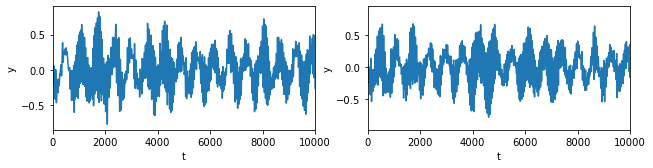

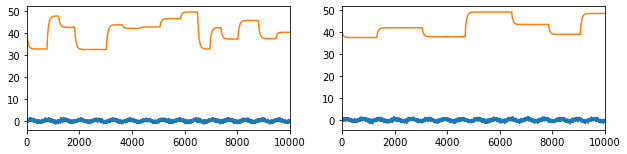

In [4]:
plt.figure(figsize=(16,5))
xlim = (0,10_000)
for i,traini in enumerate(train,start=1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    traini.plot()
for i,testi in enumerate(test,start=len(train)+1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    testi.plot()
plt.show()

plt.figure(figsize=(16,5))
for i,traini in enumerate(train,start=1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    plt.plot(traini.u)
for i,testi in enumerate(test,start=len(train)+1):
    plt.subplot(2,3,i)
    plt.xlim(xlim)
    plt.plot(testi.u)
plt.show()



In [8]:
sys = LPV_single_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10))
sys.fit(train,test,epochs=100000, loss_kwargs=dict(nf=60,loss_nf_cutoff=0.20**2),concurrent_val=True)

Initilizing the model and optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    1, sqrt loss  0.7354, Val sim-NRMS    nan, Time Loss: 85.7%, data: 11.7%, val: 2.6%,  0.0 vals/epoch, 226.1 batches/sec
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 Epoch    2, sqrt loss  0.3143, Val sim-NRMS    nan, Time Loss: 88.9%, data: 9.0%, val: 2.1%,  0.0 vals/epoch, 236.1 batches/sec
1 1 2 2 1 1 1 1 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 Epoch    3, sqrt loss  0.3913, Val sim-NRMS    nan, Time Loss: 91.0%, data: 7.2%, val: 1.7%,  0.0 vals/epoch, 213.6 batches/sec
2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 2 2 2 3 2 2 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 Epoch    4, sqrt loss  0.2217, Val sim-NRMS    nan, Time Loss: 92.1%, data: 6.2%, val: 1.7%,  0.0 vals/epoch, 185.7 batches/sec
3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 Epoch    5, sqrt loss  0.1886, Val sim-NRMS    nan, Time Loss: 93.1%, data: 5.6%, val: 1.3%,  0.0 vals/epoc

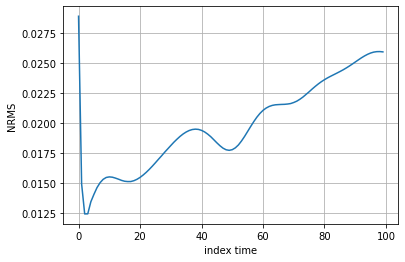

In [9]:
sys.n_step_error_plot(test[0])

In [10]:
sys.save_system('sys_LPV_single-nx-5-Np-3-nf-60V2')

In [11]:
sys_LPV_single = deepSI.load_system('sys_LPV_single-nx-5-Np-3-nf-60V2')
test_p = sys_LPV_single.apply_experiment(test)

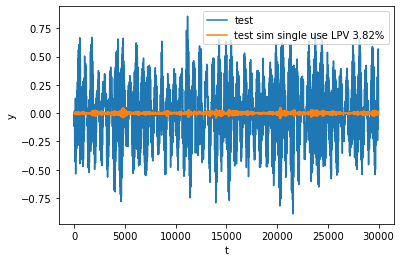

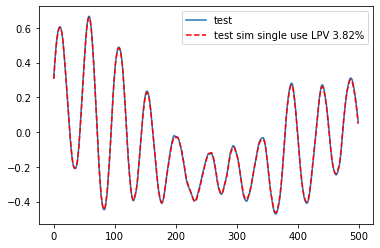

In [16]:
test.plot()
(test_p - test).plot()
plt.legend(['test',f'test sim single use LPV {test_p.NRMS(test):.2%}'])
plt.show()
plt.plot(test.y[500:1000])
plt.plot(test_p.y[500:1000],'--r')
plt.legend(['test',f'test sim single use LPV {test_p.NRMS(test):.2%}'])
plt.show()



System_data of length: 1000 nu=2 ny=None normed=False dt=None

Initilizing the model and optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

BrokenPipeError: [WinError 109] The pipe has been ended

In [21]:
out = deepSI.fit_systems.grid_search(deepSI.fit_systems.SS_linear, sys_data=test[0],sys_dict_choices=dict(nx=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]), fit_dict_choices=dict(SS_f=[1,2,3,4,5,8,10,15,20,25,30,40,50,70,90,100]))
# sys = deepSI.fit_systems.SS_linear(nx=4)
# sys._fit(train[1])
# test_p = sys.apply_experiment(test)


1.0258274019161353 {'nx': 1} {'SS_f': 1}
0.9747702742510781 {'nx': 1} {'SS_f': 2}
0.8889629685092894 {'nx': 1} {'SS_f': 3}
0.9031006053384619 {'nx': 1} {'SS_f': 4}
0.9122934477009518 {'nx': 1} {'SS_f': 5}
0.9014870208600478 {'nx': 1} {'SS_f': 8}
0.9240750032901112 {'nx': 1} {'SS_f': 10}
0.8858259872006482 {'nx': 1} {'SS_f': 15}
1.0076077515950563 {'nx': 1} {'SS_f': 20}
1.0323522358450354 {'nx': 1} {'SS_f': 25}
733011.2173196969 {'nx': 1} {'SS_f': 30}
1.0166207319409977 {'nx': 1} {'SS_f': 40}
1.0126498362923262 {'nx': 1} {'SS_f': 50}
1.0077575696135639 {'nx': 1} {'SS_f': 70}
1.002047932381433 {'nx': 1} {'SS_f': 90}
1.0018218803748802 {'nx': 1} {'SS_f': 100}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0) for sys_dict= {'nx': 2} for fit_dict= {'SS_f': 1}
inf {'nx': 2} {'SS_f': 1}
0.9123589599775208 {'nx': 2} {'SS_f': 2}
0.925376976124379 {'nx': 2} {'SS_f': 3}
0.9046536829571077 {'nx': 2} 

D:\Programs\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


error Singular matrix for sys_dict= {'nx': 6} for fit_dict= {'SS_f': 20}
inf {'nx': 6} {'SS_f': 20}
0.8057258868572037 {'nx': 6} {'SS_f': 25}
0.6889025909338604 {'nx': 6} {'SS_f': 30}
0.8045095577065997 {'nx': 6} {'SS_f': 40}
0.7588332812633595 {'nx': 6} {'SS_f': 50}
0.7407578871014312 {'nx': 6} {'SS_f': 70}
0.7286217592307547 {'nx': 6} {'SS_f': 90}
0.7879458091111958 {'nx': 6} {'SS_f': 100}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (1,1) and (7,) not aligned: 1 (dim 1) != 7 (dim 0) for sys_dict= {'nx': 7} for fit_dict= {'SS_f': 1}
inf {'nx': 7} {'SS_f': 1}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (2,2) and (7,) not aligned: 2 (dim 1) != 7 (dim 0) for sys_dict= {'nx': 7} for fit_dict= {'SS_f': 2}
inf {'nx': 7} {'SS_f': 2}
Warning! The horizon must be larger than the model order, max_order setted as future
error shapes (3,3) and (7,) not aligned: 3 (dim 1) != 7 (dim 0) for sy

In [22]:
sim_val, sysLTI, sys_d, fit_d = out

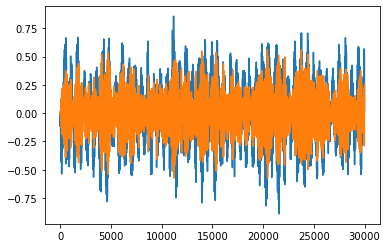

In [23]:
plt.plot(test.y)
plt.plot((sysLTI.apply_experiment(test)-test).y)
plt.show()

In [35]:
# sys = deepSI.fit_systems.SS_encoder(nx=6) #LPV_single_encoder(nx=8, na=5, nb=5)
#nx = 3 or 4?
#0.6399 for LTI
for l in sys.optimizer.state_dict()['param_groups']:
    l['lr'] = 0.0001
sys.fit(train, test[0], epochs=100000, loss_kwargs=dict(nf=150),concurrent_val=True)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  38.3 MB
N_training_samples = 9831, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch    1, sqrt loss  0.1058, Val sim-NRMS 0.1871, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    2, sqrt loss  0.5901, Val sim-NRMS  0.291, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    3, sqrt loss  0.6922, Val sim-NRMS 0.7584, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.1 batches/sec
Epoch    4, sqrt loss  0.4686, Val sim-NRMS 0.7359, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    5, sqrt loss  0.1578, Val sim-NRMS 0.5384, Time Loss: 99.6%, data: 0.2%, val: 0.2%,  1.0 epochs/val,  7.0 batches/sec
Epoch    6, sqrt loss 0.09791, Val sim-NRMS 0.2697, Time Loss: 99.6%, data: 0.2%, val: 0.2%, 1.17 vals/epoch,  7.0 batches/sec
Epoch    7, sqrt loss 0.08087, Val sim-NRMS  0.215, Time Loss: 99.6%, data: 0.2%, val: 0.2%, 1.14 vals/epoch,  7.0 batches/sec
Epoch    8, sqrt loss 0.08438, Val sim-NRMS 0.2055, Time Loss: 99.6%, data: 0.2%, val: 0.2%, 1.12 vals/epoch,  

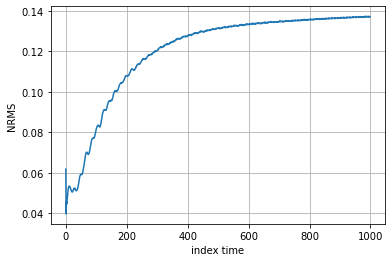

In [39]:
sys.n_step_error_plot(test[0], nf=1000,stride=10)

In [100]:
# train, test = deepSI.datasets.Silverbox()



# sys_LPV_single.init_model(sys_data=train)
# sys_LPV_single.apply_experiment(test[0][:10_000]).plot()
# torch.abs(torch.linalg.eigvals(sys_LPV_single.fn.As[0])), torch.abs(torch.linalg.eigvals(sys_LPV_single.fn.A)) #its nost unstable in 

In [112]:
# sys_LPV_single = LPV_single_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10)) #LPV_single_encoder(nx=8, na=5, nb=5)
# sys_LPV_single.checkpoint_load_system('_last')
sys_LPV_single.fit(train, test, epochs=100000, loss_kwargs=dict(nf=60), concurrent_val=True)#, optimizer_kwargs=dict(lr=0.0001))

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  14.8 MB
N_training_samples = 9936, batch_size = 256, N_batch_updates_per_epoch = 38


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch    1, sqrt loss 0.07409, Val sim-NRMS  0.057, Time Loss: 99.7%, data: 0.3%, val: 0.0%,  0.0 vals/epoch,  6.4 batches/sec
Epoch    2, sqrt loss  0.1531, Val sim-NRMS  0.057, Time Loss: 99.7%, data: 0.2%, val: 0.0%,  0.0 vals/epoch,  6.4 batches/sec
Epoch    3, sqrt loss 0.04811, Val sim-NRMS  0.057, Time Loss: 99.6%, data: 0.2%, val: 0.1%,  3.0 epochs/val,  6.2 batches/sec
Epoch    4, sqrt loss 0.04267, Val sim-NRMS  0.057, Time Loss: 99.6%, data: 0.3%, val: 0.1%,  4.0 epochs/val,  6.3 batches/sec
Epoch    5, sqrt loss 0.04043, Val sim-NRMS 0.1336, Time Loss: 99.6%, data: 0.2%, val: 0.1%,  2.5 epochs/val,  6.2 batches/sec
Epoch    6, sqrt loss 0.04042, Val sim-NRMS 0.1336, Time Loss: 99.6%, data: 0.2%, val: 0.1%,  3.0 epochs/val,  6.2 batches/sec
Epoch    7, sqrt loss  0.1178, Val sim-NRMS 0.1195, Time Loss: 99.6%, data: 0.2%, val: 0.1%, 2.33 epochs/val,  6.2 batches/sec
Epoch    8, sqrt loss 0.07044, Val sim-NRMS 0.1195, Time Loss: 99.6%, data: 0.2%, val: 0.1%, 2.67 epochs/val,  

In [113]:
sys_LPV_single.save_system('sys_LPV_single-nx-5-Np-3-nf-60')

In [25]:
# sys.checkpoint_load_system('_last')
#todo's
# 1. Start fitting and get a result below 
#F=100 unstable after 3 epochs???
#F=1000 also unstable? Np from 3 -> 1, nope
# nx from 6 to 5? nope?
# is A unstable to begin with? No? lower learning rate from 0.0005 to 0.0001? Unstable region of training?
# lr=0.00005 seems stable? at nx=6, Np=3
# lr = 0.000075 also stable?
# lr = 0.0001 is unstable?
# is it a data property -> Check Silverbox?
# lower nf initially? Yes!, I don't know why it is so unstable to begin with. 

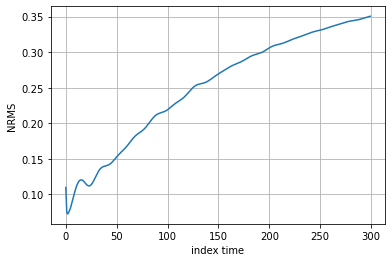